# Land handling effect  
In this notebook we compare 3 different types of land boundary conditions for 2 types of particles. The types of boundary  
conditions tested are:
1. none 
2. anti beaching current
3. free slip

We use these bc in a silation with the CMEMS NWES dataset, where we simulate the particles starting on 1 sep 2023 for 1 month.   
We consider 2 "types" of particles (1) tracer particles and (2) inertial particles (stokes drifters). The inertial particles  
are advected with the slow manifold maxey riley equation (MRSM). For both types we use an RK4 algorithm.   
  
In principle the in principle the free slip boundary condition would be better as it has less impact of the trajectory of   
particles and should prevent particles getting stuck. However as the intertial particleas also contain derivatives of the  
velocity field (implemented as finite differences) we will check whether this also is the case for these particles.  
 

In [7]:
# import needed packages
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from decimal import Decimal
import plotly.express as px # for 3d plotting
from datetime import datetime, timedelta
from analysis_functions import trajectory_length,  make_PDF, Haversine, running_mean
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
from helper import create_filelist

# set plotstyle
plt.style.use('../python_style_Meike.mplstyle')

#set needed constants
Rearth = 6371 * 10**3 # in k,
deg2rad = np.pi / 180.

#set directotories and template filenames
base_directory = '/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/'

basefile_MRSM = (base_directory + 'inertial_SM/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}.zarr')

basefile_tracer = (base_directory + 'tracer/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_{land_handling}.zarr')


 #to check whether timesteps does have an effect on amount of beached particles for the free slip bc (spoiler: it doesn't )
basefile_tracer_fs = (base_directory + 'tracer/{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_{land_handling}_small_timesteps.zarr') 

land_handlings = ['none','anti_beaching','free_slip','partialslip']
types = ['MRSM','tracer']
type_folders={'MRSM':basefile_MRSM,'tracer':basefile_tracer}

dims = {}
dims['anti_beaching'] ={'lon':'lon_ab', 'lat':'lat_ab','time':'time_ab','vorticity':'vorticity_ab'}
dims['free_slip'] ={'lon':'lon_fs', 'lat':'lat_fs','time':'time_fs','vorticity':'vorticity_fs'}
dims['partialslip'] ={'lon':'lon_ps', 'lat':'lat_ps','time':'time_ps','vorticity':'vorticity_ps'}
dims['none'] ={'lon':'lon_none', 'lat':'lat_none','time':'time_none','vorticity':'vorticity_none'}


In [8]:
# general settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
runtime=timedelta(30)
nparticles = 88347 # 52511
displacement = 100 #m

starttimes = np.array([datetime(2023, 9, 1, 0, 0, 0, 0)]) #,
                    #    datetime(2023, 10, 1, 0, 0, 0, 0),
                    #    datetime(2023, 11, 1, 0, 0, 0, 0),
                    #    datetime(2023, 12, 1, 0, 0, 0, 0) ])#,
                       #datetime(2024, 1, 1, 0, 0, 0, 0),
                       #datetime(2024, 2, 1, 0, 0, 0, 0)])

date_new = datetime(2023, 9, 1, 0, 0, 0, 0)


In [9]:
# import data

chunck_time = 100
years = np.array([2023,2024])
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
data = {}
for ty in types:
    data[ty]={}
    for year in years:
        data[ty][year]={}
traj = np.arange(0,nparticles,1)

for ty in types:
    ds_list=[]
    for starttime in starttimes:
        endtime = starttime + runtime 
        for land_handling in  land_handlings:
            file =  type_folders[ty].format(loc=loc,
                                                            type_folder=type_folders[ty], 
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling)
            print(file)

            ds = xr.open_dataset(file,
                            engine='zarr',
                            chunks={'trajectory':nparticles, 'obs':chunck_time},
                            drop_variables=['B','tau','z'],
                            decode_times=False)  #,decode_cf=False)
            ds = ds.rename(dims[land_handling])
            ds = ds.assign_coords({'trajectory':traj})
            ds_list.append(ds)
            print(land_handling)

    data[ty][starttime.year][starttime.month] = xr.merge(ds_list)


/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_SM/NWES_start2023_09_01_end2023_10_01_RK4_B0680_tau2759_none.zarr
none
/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_SM/NWES_start2023_09_01_end2023_10_01_RK4_B0680_tau2759_anti_beaching.zarr
anti_beaching
/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_SM/NWES_start2023_09_01_end2023_10_01_RK4_B0680_tau2759_free_slip.zarr
free_slip
/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_SM/NWES_start2023_09_01_end2023_10_01_RK4_B0680_tau2759_partialslip.zarr
partialslip
/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/tracer/NWES_start2023_09_01_end2023_10_01_RK4_none.zarr
none
/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/tracer/NWES_start2023_09_01_end2023_10_01_RK4_anti_beaching.zarr
anti_beaching
/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/tracer/N

In [10]:
year=2023
month=9
ty='MRSM'
data[ty][year][month]

<xarray.Dataset> Size: 6GB
Dimensions:         (trajectory: 88347, obs: 800)
Coordinates:
  * obs             (obs) int32 3kB 0 1 2 3 4 5 6 ... 794 795 796 797 798 799
  * trajectory      (trajectory) int64 707kB 0 1 2 3 ... 88343 88344 88345 88346
Data variables: (12/16)
    lat_none        (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    lon_none        (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    time_none       (trajectory, obs) float64 565MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    vorticity_none  (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    lat_ab          (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    lon_ab          (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    ...              ...
    time_fs         (trajectory, obs) float64 565MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    vorticity_fs    (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    lat_ps          (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    lon_ps          (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    time_ps         (trajectory, obs) float64 565MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
    vorticity_ps    (trajectory, obs) float32 283MB dask.array<chunksize=(88347, 100), meta=np.ndarray>
Attributes: (12/14)
    Conventions:            CF-1.6/CF-1.7
    delta_x:                0.013889312744140625
    delta_y:                0.013889312744140625
    dt:                     300.0
    feature_type:           trajectory
    land_handling:          none
    ...                     ...
    parcels_kernels:        InertialParticle2Dtoo_close_to_edgemeasure_vortic...
    parcels_mesh:           spherical
    parcels_version:        3.0.6
    particle_type:          inertial_SM
    runtime:                2592000.0
    write_dt:               3600.0

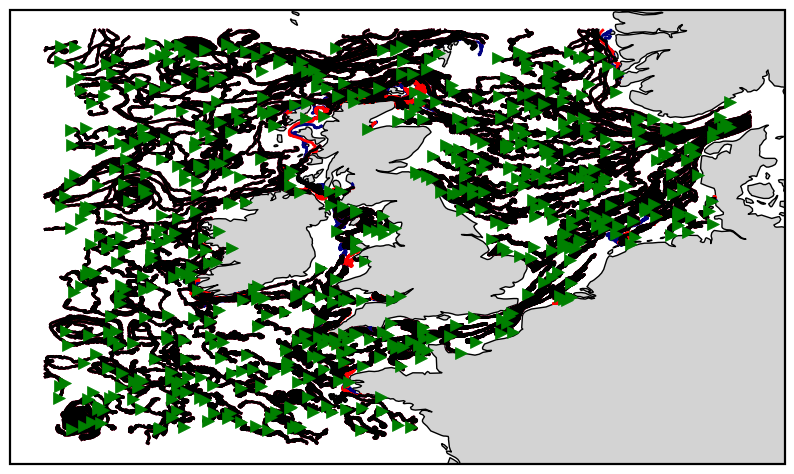

In [304]:
# plot selection of trajectories

year=2023
month=9
ty='tracer'

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(data[ty][year][month]['lon_ab'][50000:80000:50,0].values,
        data[ty][year][month]['lat_ab'][50000:80000:50,0].values,
        '>',
        color='green',
        zorder=20)
ax.plot(data[ty][year][month]['lon_ab'][50000:80000:50,0::1].values.T,
        data[ty][year][month]['lat_ab'][50000:80000:50,0::1].values.T,
        '-',
        color='navy');

ax.plot(data[ty][year][month]['lon_fs'][50000:80000:50,0::1].values.T,
        data[ty][year][month]['lat_fs'][50000:80000:50,0::1].values.T,
        '-',
        color='red');

ax.plot(data[ty][year][month]['lon_none'][50000:80000:50,0::1].values.T,
        data[ty][year][month]['lat_none'][50000:80000:50,0::1].values.T,
        '-',
        color='black');



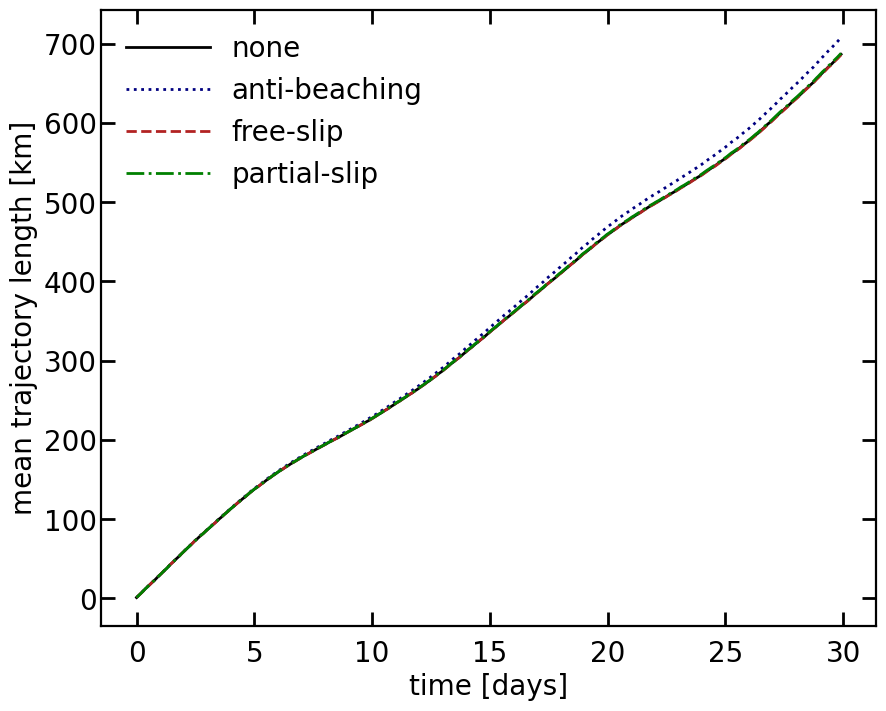

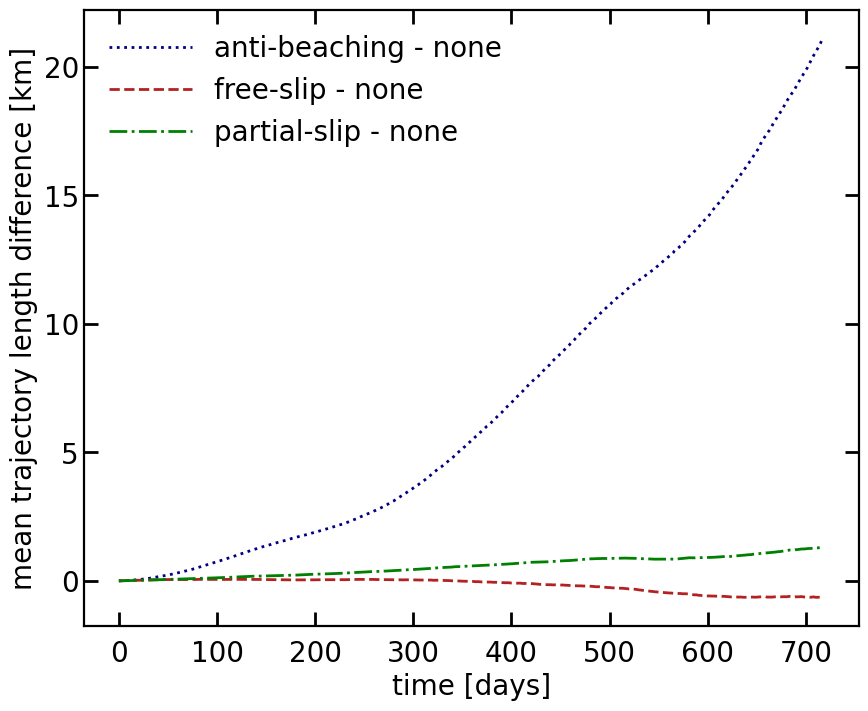

In [28]:
# check for stuck particles
ty='MRSM'
year=2023
month=9
tend=720
time = np.arange(0,tend-1,1)/24
ds= data[ty][year][month]

traj_length_ab = trajectory_length(ds.lon_ab[:,:tend], ds.lat_ab[:,:tend])
traj_length_fs = trajectory_length(ds.lon_fs[:,:tend], ds.lat_fs[:,:tend])
traj_length_ps = trajectory_length(ds.lon_ps[:,:tend], ds.lat_ps[:,:tend])
traj_length_none = trajectory_length(ds.lon_none[:,:tend], ds.lat_none[:,:tend])
diff_traj_ab = np.diff(traj_length_ab,axis=1,n=1)
diff_traj_fs =np.diff(traj_length_fs,axis=1,n=1)
diff_traj_ps =np.diff(traj_length_ps,axis=1,n=1)
diff_traj_none =np.diff(traj_length_none,axis=1,n=1)
traj_length_none_mean = np.nanmean(traj_length_none,axis=0)
traj_length_fs_mean = np.nanmean(traj_length_fs,axis=0)
traj_length_ps_mean = np.nanmean(traj_length_ps,axis=0)
traj_length_ab_mean = np.nanmean(traj_length_ab,axis=0)

fig,ax=plt.subplots()
ax.plot(time,traj_length_none_mean,'-',color='black')
ax.plot(time,traj_length_ab_mean,':',color='navy')
ax.plot(time,traj_length_fs_mean,'--',color='firebrick')
ax.plot(time,traj_length_ps_mean,'-.',color='green')

ax.set_xlabel('time [days]')
ax.set_ylabel('mean trajectory length [km]')
ax.legend(['none','anti-beaching','free-slip','partial-slip'])


fig, ax = plt.subplots()
ax.plot(traj_length_ab_mean-traj_length_none_mean,':',color='navy')
ax.plot(traj_length_fs_mean-traj_length_none_mean,'--',color='firebrick')
ax.plot(traj_length_ps_mean-traj_length_none_mean,'-.',color='green')
ax.set_xlabel('time [days]')
ax.set_ylabel('mean trajectory length difference [km]')
ax.legend(['anti-beaching - none','free-slip - none','partial-slip - none'])


slow manifold MR:
Trajectory length of free slip is shorter than no boundary condition, maybe because it alsready slows down a bit close to the boundary?
The none bc should have stuck particles so that is what we will analyse below. 


(-0.1, 3.0)

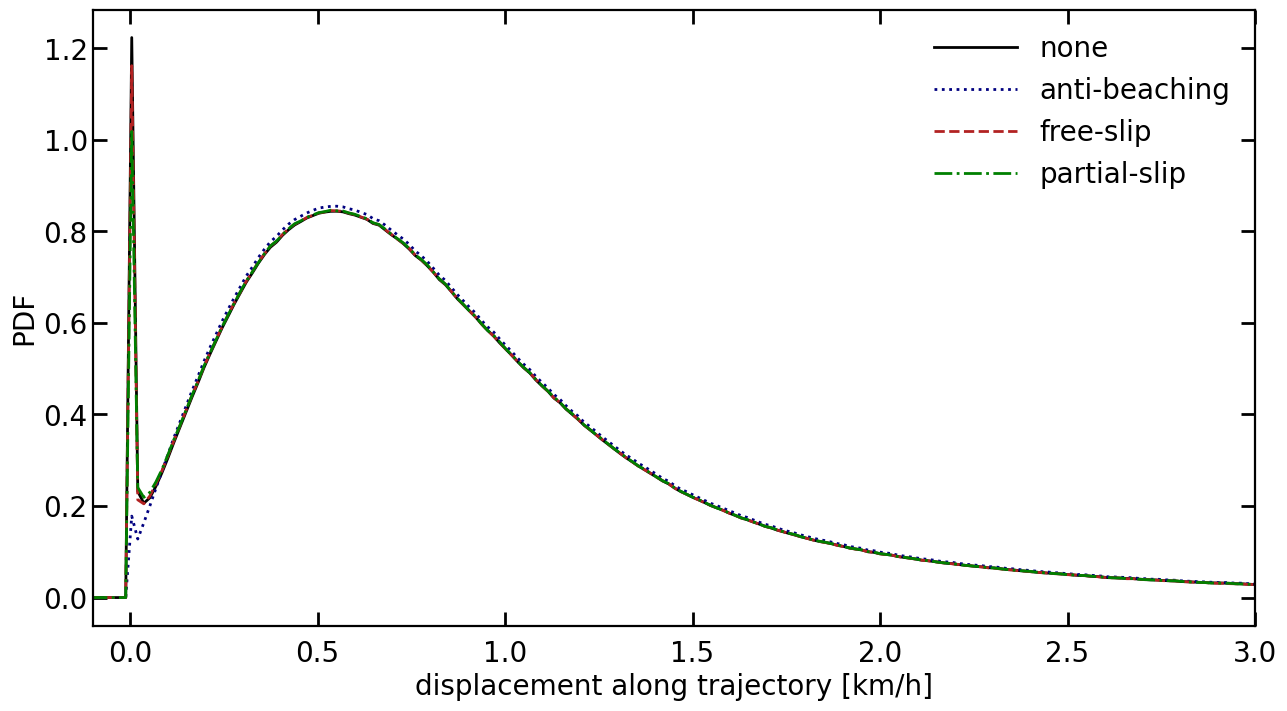

In [29]:
fig,ax=plt.subplots(figsize=(15,8))
array_ab=diff_traj_ab[:,0:700].flatten()
array_ab=array_ab[~np.isnan(array_ab)]
bins_ab,pdf_ab = make_PDF(array_ab,nbins=1001,norm=True, min=-0.1, max=16)

array_fs=diff_traj_fs[:,0:700].flatten()
array_fs=array_fs[~np.isnan(array_fs)]
bins_fs,pdf_fs = make_PDF(array_fs,nbins=1001,norm=True, min=-0.1, max=16)

array_ps=diff_traj_ps[:,0:700].flatten()
array_ps=array_ps[~np.isnan(array_ps)]
bins_ps,pdf_ps = make_PDF(array_ps,nbins=1001,norm=True, min=-0.1, max=16)


array_none=diff_traj_none[:,0:700].flatten()
array_none=array_none[~np.isnan(array_none)]
bins_none,pdf_none = make_PDF(array_none,nbins=1001,norm=True, min=-0.1, max=16)

ax.plot(bins_none,pdf_none,'-',color='black')
ax.plot(bins_ab,pdf_ab,':',color='navy')
ax.plot(bins_fs,pdf_fs,'--',color='firebrick')
ax.plot(bins_ps,pdf_ps,'-.',color='green')


# no stuck particles :) 
ax.legend(['none', 'anti-beaching','free-slip','partial-slip'])
ax.set_xlabel('displacement along trajectory [km/h]')
ax.set_ylabel('PDF')

ax.set_xlim(-0.1,3)

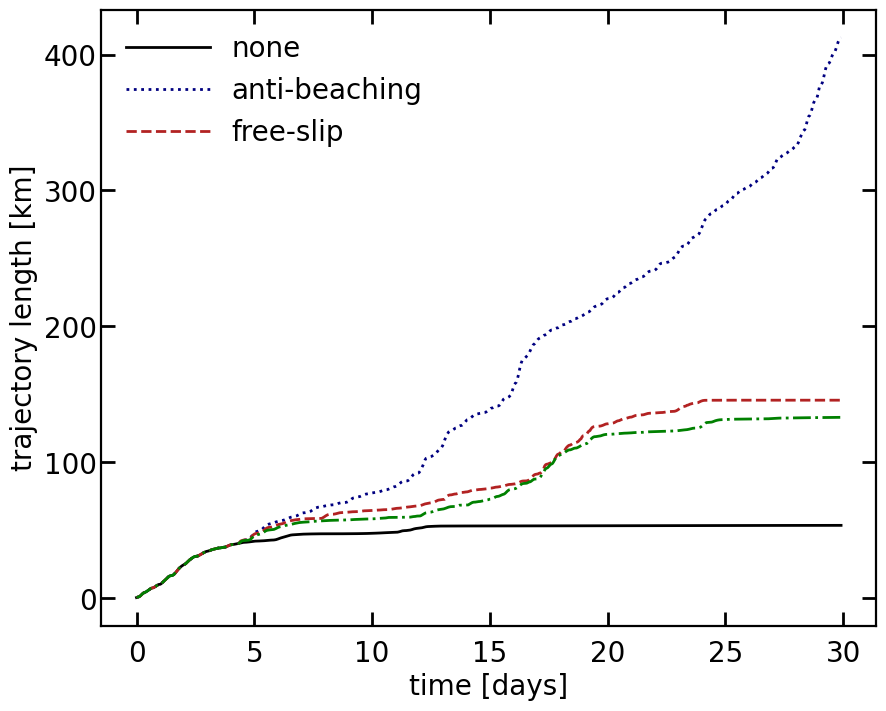

In [16]:
fig,ax=plt.subplots()
i=104
ax.plot(time,traj_length_none[i],'-',color='black')
ax.plot(time,traj_length_ab[i],':',color='navy')
ax.plot(time,traj_length_fs[i],'--',color='firebrick')
ax.plot(time,traj_length_ps[i],'-.',color='green')

ax.set_xlabel('time [days]')
ax.set_ylabel('trajectory length [km]')
ax.legend(['none', 'anti-beaching','free-slip'])

In [ ]:
# find stuck particles using the trajectory displacement
test=diff_traj_fs[:,700]
indices=np.arange(0,nparticles,1)
select =indices[test<10**(-10)]
print(select.size)
print(select)

915
[    5   104   129   287   349   367   584   639   695   848   854   953
   999  1026  1183  1385  1435  1468  1516  1544  1551  1692  1718  1738
  1824  1943  2315  2458  2573  2871  2960  3016  3052  3116  3144  3399
  3841  3849  3965  3975  3987  4022  4242  4301  4333  4352  4365  4870
  5076  5085  5202  5312  5361  5408  5594  5674  5719  5992  6034  6042
  6190  6395  6498  6633  6706  6773  6909  6941  6962  7054  7092  7178
  7581  7595  7598  7718  7892  7961  8152  8198  8331  8408  8451  8615
  8646  8915  8968  9060  9167  9249  9391  9783  9835  9869  9948 10011
 10045 10118 10185 10253 10272 10298 10473 10500 10738 10996 11084 11152
 11265 11386 11492 11516 11594 11810 12078 12122 12299 12488 12805 12864
 12891 12939 13052 13126 13141 13173 13189 13318 13373 13466 13503 13730
 13827 13877 14146 14200 14209 14391 14462 14632 14691 14817 14884 15009
 15081 15094 15162 15260 15299 15367 15487 15581 15825 15851 15899 16077
 16140 16189 16287 16414 16457 16462 16498 1651

<xarray.Dataset> Size: 5MB
Dimensions:      (x: 551, y: 936)
Coordinates:
    lon          (x, y) float32 2MB ...
    lat          (x, y) float32 2MB ...
Dimensions without coordinates: x, y
Data variables:
    mask_land    (x, y) bool 516kB ...
    explanation  <U9 36B ...


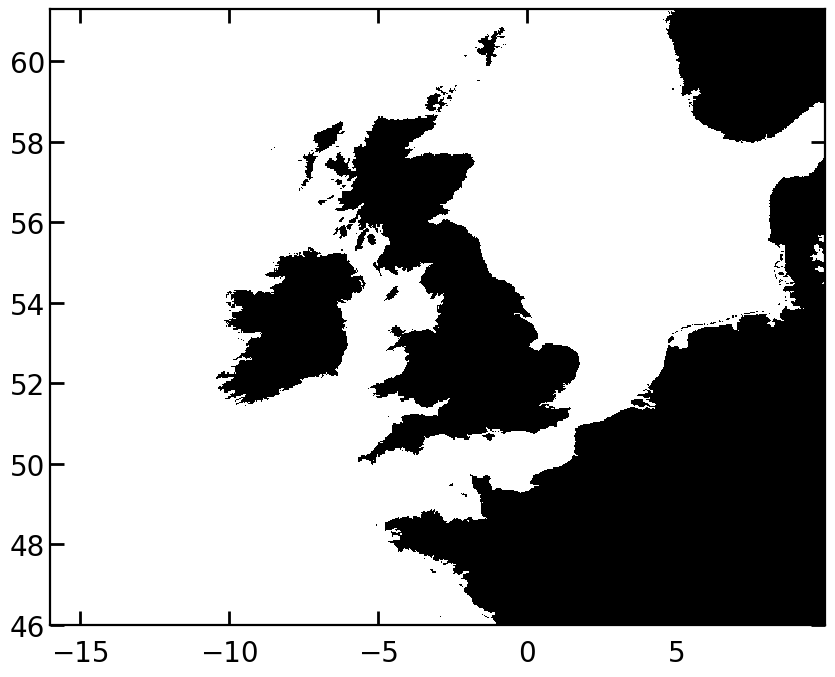

In [18]:
# import mesh
mask_land = xr.open_dataset('/storage/shared/oceanparcels/output_data/data_Meike/NWES/NWS_mask_land_new.nc')
print(mask_land)
fig,ax=plt.subplots()
ax.pcolormesh(mask_land.lon,mask_land.lat,mask_land.mask_land,cmap='Greys')

0.027778625


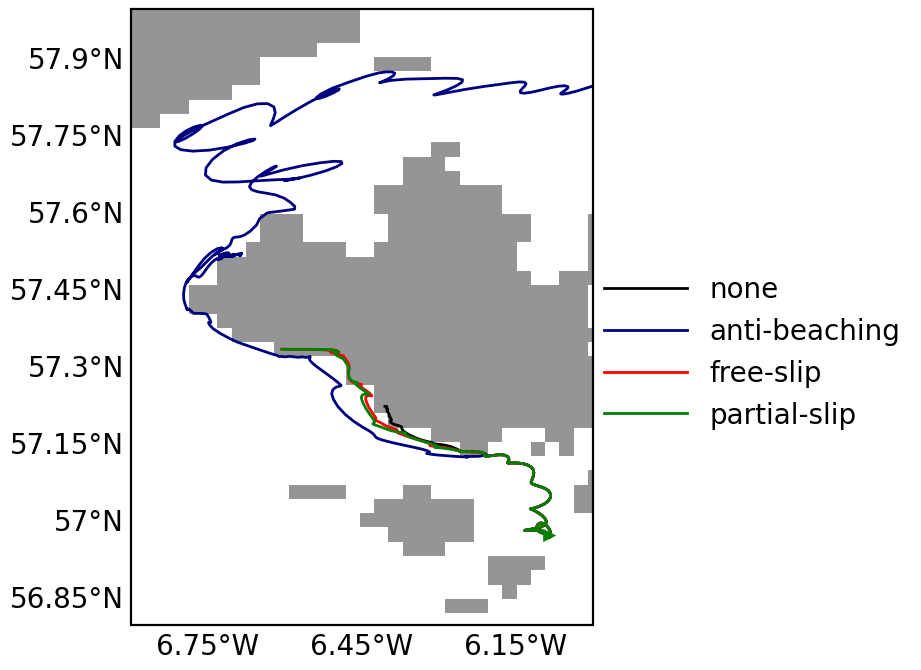

In [27]:

year=2023
month=9
ty='MRSM'

ds = data[ty][year][month]

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
# ax.coastlines()

index= 104 # 1235 8537 20 66
# ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
dlon = (mask_land.lon[0,1]-mask_land.lon[0,0]).values
dlat = (mask_land.lat[1,0]-mask_land.lat[0,0]).values
print(dlat)
ax.pcolormesh(mask_land.lon,mask_land.lat,mask_land.mask_land,cmap='Greys',vmin=0,vmax=2, shading = 'auto')

ax.plot(ds['lon_none'][index,0::1].values,
        ds['lat_none'][index,0::1].values,
        '-',
        color='black');

ax.plot(ds['lon_ab'][index,0::1].values,
        ds['lat_ab'][index,0::1].values,
        '-',
        color='navy');

ax.plot(ds['lon_fs'][index,0::1].values,
        ds['lat_fs'][index,0::1].values,
        '-',
        color='red');

ax.plot(ds['lon_ps'][index,0::1].values,
        ds['lat_ps'][index,0::1].values,
        '-',
        color='green');




gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style =  {'size': 20}
    # axs[a].set_xlim(-3,9.5)
ax.set_xlim(-6.9,-6)
ax.set_ylim(56.8,58)

# ax.set_xlim(-8,-6)
# ax.set_ylim(55.5,58)
ax.set_xlabel('longitude [$^{\\circ}$]')
ax.set_ylabel('latitude [$^{\\circ}$]')

ax.legend(['none', 'anti-beaching','free-slip','partial-slip'],loc=(1,0.3))

ax.plot(ds['lon_ab'][index,0].values,
        ds['lat_ab'][index,0].values,
        '>',
        color='green',
        zorder=20)

# Conclusion
For the tracer particles, free slip does result in less non-moving particles (but still some?). For MR particles the free slip bc does result in almost as much non-moving particles as 

Free slip does not result in a lot of stuck particles (to do: also use one without any land bc to show taht that particles actually get stuck.)